# Numerical experiements for the complete graph
This document reproduces the results of the paper for a complete graph.

## 1. Imports

In [12]:
# Maths
import numpy as np
import math 
from math import pi 
# Plot
import matplotlib.pyplot as plt
import seaborn as sns
# Graph
import networkx as nx 
# Utilities
import copy
from tqdm.auto import tqdm
import pandas as pd
import sys
# Fit
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
# Parallelisation
from multiprocessing import Pool
# QWSearch
from qwgraph import QWSearch,coins,PipeLine,AddressingType,pipelines

# Plot configuration
sns.set()
sns.set_context("poster")
sns.set_style("ticks")

idc = lambda x : np.array(list(range(len(x))))

## 2. Signal of a search
We search one node in the complete bipartite graph according to the procedure explained in the paper.
 1. Generate a complete bipartite graph graph
 2. Starify it
 3. Mark the right virtual edge
 4. Search with the QW

Text(0, 0.5, 'probability of success')

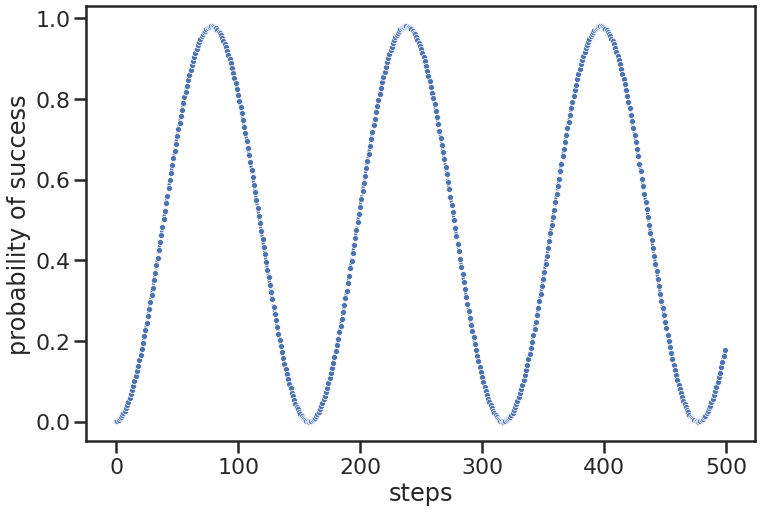

In [13]:
G = nx.convert_node_labels_to_integers(nx.complete_graph(100)) # Initial graph : complete bipartite graph
qw = QWSearch(G, starify=True) # Generation of the QW
searched = [0]
p = qw.run(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X), ticks=500) # The signal of the walk

plt.figure(figsize=(12,8))
sns.lineplot(x=idc(p),y=p,marker='.', linestyle='--')
plt.xlabel("steps")
plt.ylabel("probability of success")

## 3. Hitting time and probability of success for the balanced complete bipartite graph
We will now compute the hitting time $T$ and the probability of success $P$ for different graph sizes.
The algorithm used to compute the hitting time is as follow:
 1. Set S = [p(0)]
 2. Compute the 30 first steps of the signal S : S = [p(0),...,p(30)]
 3. Set a = argmin(S) and b = argmax(S)
 4. If S[-1] > $\frac{a+b}{2}$ then return (T=b, P=S[b])
 5. Else, compute next step and go back to step 4.

The full code for this can be found in ./pqwfast.py -> fn carac

In [14]:
def lin_fit(x,y):
    X = np.array([[i] for i in x])
    reg = LinearRegression().fit(X, y)
    text = "score : {:.5f}\nintercept : {:.5f}\ncoef : {:.5f}\n".format(reg.score(X,y),reg.intercept_,reg.coef_[0])
    print(text)
    return reg.predict(X), text

In [15]:
def get_T_P(n):
    """
    Parameter:
        n -> The width of the grid.
    Return:
        pandas dataframe with a lot of informations on the search.
    """
    G = nx.convert_node_labels_to_integers(nx.complete_graph(n))
    qw = QWSearch(G, starify=True) # Generation of the QW
    searched = [0]
    T,P = qw.get_T_P(pipelines.search_virtual_edges(coins.X, "grover", searched, -coins.X),waiting=30)
    dic = {"$N$":len(list(G.nodes())), "$M$":len(list(G.edges())), "$\\tilde N$":len(list(qw.nodes())), "$\\tilde M$":len(list(qw.edges())),
            "degree_centrality $G$":nx.degree_centrality(G)[0], "degree_centrality $\\tilde G$":nx.degree_centrality(qw.graph())[0], "$T$":T, "$P$":P,}
    return pd.DataFrame({i : [dic[i]] for i in dic})

get_T_P(100)

,$N$,$M$,$\tilde N$,$\tilde M$,degree_centrality $G$,degree_centrality $\tilde G$,$T$,$P$
0,100,4950,200,5050,1.0,0.502513,79,0.980847


In [16]:
# This cell compute data for a lot of grid size (might take a while).
graph_sizes = list(range(50,500,5))
np.random.shuffle(graph_sizes)
with Pool(16) as p:
    data = pd.concat(list(tqdm(p.imap_unordered(get_T_P,graph_sizes), total=len(graph_sizes), desc="Computing hitting time and probability of success for various graph sizes")))

Computing hitting time and probability of success for various graph sizes:   0%|          | 0/90 [00:00<?, ?it…

### 3.1 Hitting time

score : 0.99997
intercept : 0.21216
coef : 1.11174



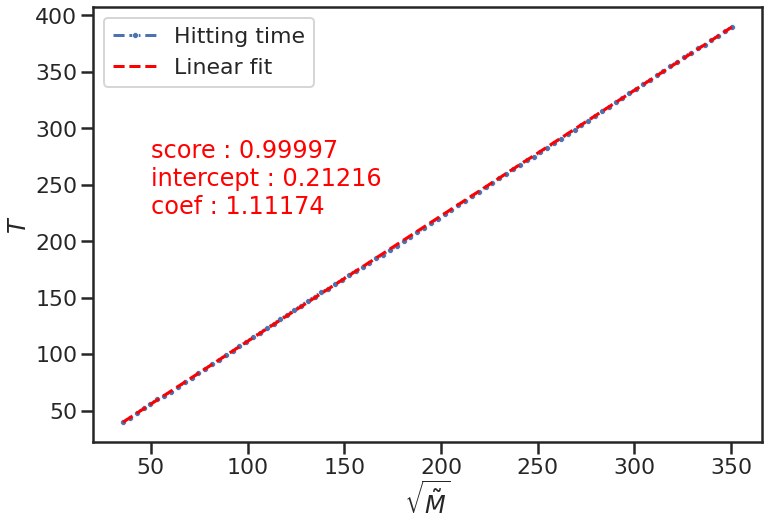

In [17]:
x = np.sqrt(data["$\\tilde M$"])
y = np.array(list(data["$T$"]))
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--', label="Hitting time")
sns.lineplot(x=x,y=z, linestyle='--', color="red", label = "Linear fit")
plt.annotate(text, xy=(50, 200),color="red")
plt.xlabel("$\\sqrt{\\tilde M}$")
plt.ylabel("$T$")
plt.savefig("img/complete_T.png", bbox_inches='tight')

score : 0.99997
intercept : 0.60405
coef : 0.78612



Text(0, 0.5, '$T$')

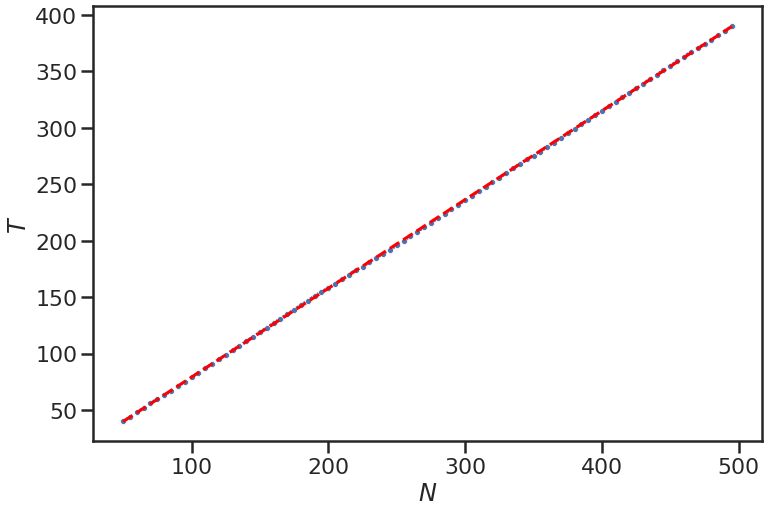

In [18]:
x = np.array(list(data["$N$"]))
y = np.array(list(data["$T$"]))
z, text = lin_fit(x,y)

plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--')
sns.lineplot(x=x,y=z, linestyle='--', color="red")
plt.annotate(text, xy=(50, 500),color="red")
plt.xlabel("$N$")
plt.ylabel("$T$")

### 3.2 Probability of success

0.9999641332546673
[ 1.07792088  0.47005597 -0.07754202]


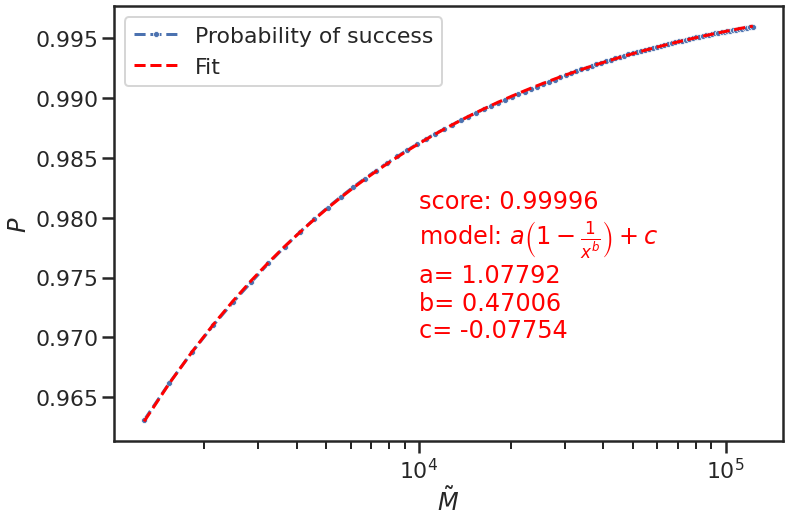

In [24]:
x = np.array(list(data["$\\tilde M$"]))
y = np.array(list(data["$P$"]))
model = lambda x,a,b,c:a*(1-1/x**b)+c
param = curve_fit(model,x,y,p0=[0.5,0.5,0.5],maxfev=100000)[0]
z = model(x,*param)

score = 1-np.mean((y-z)**2)/np.std(y)**2
print(score)
text = "score: {:.5f}\nmodel: {}\na= {}\nb= {}\nc= {}".format(score,"$a\\left(1-\\frac{1}{x^b}\\right)+c$",*np.round(param,5))

print(param)
plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--', label="Probability of success")
sns.lineplot(x=x,y=z, linestyle='--', color="red", label="Fit")
plt.annotate(text, xy=(10000, 0.97),color="red")
plt.xlabel("$\\tilde M$")
plt.ylabel("$P$")
plt.xscale("log")
plt.savefig("img/complete_P.png", bbox_inches='tight')

0.9999629809030524
[ 1.4386139   0.93253769 -0.43818367]


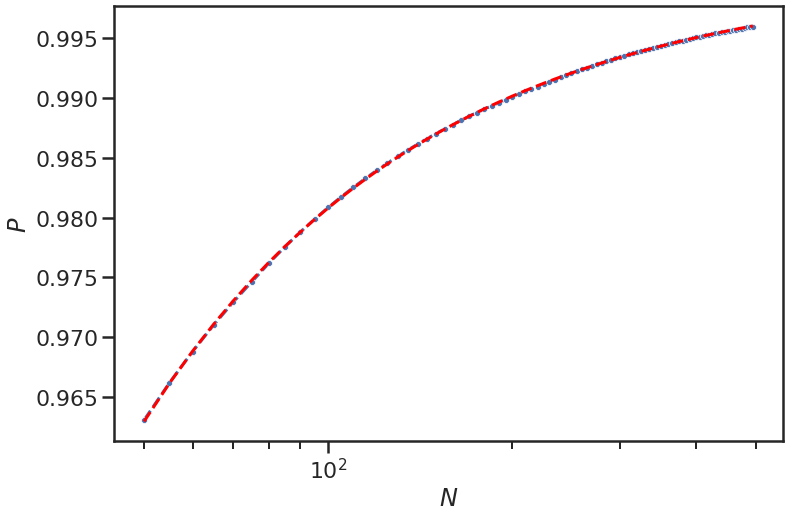

In [25]:
x = np.array(list(data["$N$"]))
y = np.array(list(data["$P$"]))
model = lambda x,a,b,c:a*(1-1/x**b)+c
param = curve_fit(model,x,y,p0=[0.5,0.5,0.5],maxfev=100000)[0]
z = model(x,*param)

score = 1-np.mean((y-z)**2)/np.std(y)**2
print(score)
text = "score : {:.5f}\nmodel : {}\n coef : {}".format(score,"$a\\left(1-\\frac{1}{x^b}\\right)+c$",np.round(param,5))

print(param)
plt.figure(figsize=(12,8))
sns.lineplot(x=x,y=y,marker='.', linestyle='--')
sns.lineplot(x=x,y=z, linestyle='--', color="red")
plt.annotate(text, xy=(80, 0.835),color="red")
plt.xlabel("$N$")
plt.ylabel("$P$")
plt.xscale("log")